In [1]:
%pip install influxdb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from influxdb import InfluxDBClient

In [3]:
# InfluxDB Connection Details
INFLUX_HOST = 'influxdb'       # The host where InfluxDB is running
INFLUX_PORT = 8086              # The port
INFLUX_USER = 'admin'           # Username
INFLUX_PASS = 'admin123'        # Password
INFLUX_DB   = 'controlled_building' # Name of the BMS database

# Configuration
PE_GAS = 1.00
PE_ELEC = 2.17
COP_H = 0.98
EER_C = 5.4
THRESHOLD_COOLING = 20  # Power threshold to filter outliers (in W)
THRESHOLD_HEATING = 150  # Power threshold to filter outliers (in W)
MEASUREMENT = "simulation_observations" # The measurement containing these fields
YEAR = 2025
START = f"{YEAR}-01-01T00:00:00Z"
END = f"{YEAR + 1}-01-01T00:00:00Z"

SECONDS_PER_INTERVAL = {
    '1h': 3600,
    '1d': 86400,
    '7d': 7 * 86400,
    '30d': 30 * 86400
}

# Initialize the Client
client = InfluxDBClient(
    host=INFLUX_HOST,
    port=INFLUX_PORT,
    username=INFLUX_USER,
    password=INFLUX_PASS,
    database=INFLUX_DB
)

assert client.ping(), "❌ Cannot reach InfluxDB"
print("✅ Connected to InfluxDB 1.x")

✅ Connected to InfluxDB 1.x


Executing query with GROUP BY time(1h)...
                   time  val             name
0  2025-01-01T00:00:00Z  NaN  DistrictCooling
1  2025-01-01T01:00:00Z  NaN  DistrictCooling
2  2025-01-01T02:00:00Z  NaN  DistrictCooling
3  2025-01-01T03:00:00Z  NaN  DistrictCooling
4  2025-01-01T04:00:00Z  NaN  DistrictCooling
Index(['time', 'val', 'name'], dtype='object')
['DistrictCooling' 'DistrictHeating' 'T_ext' 'Tair_z1' 'Tair_z2' 'Tair_z3'
 'Tair_z4']
Winter points before filtering: 4296
Winter points after filtering: 1514
Summer points before filtering: 4392
Summer points after filtering: 284


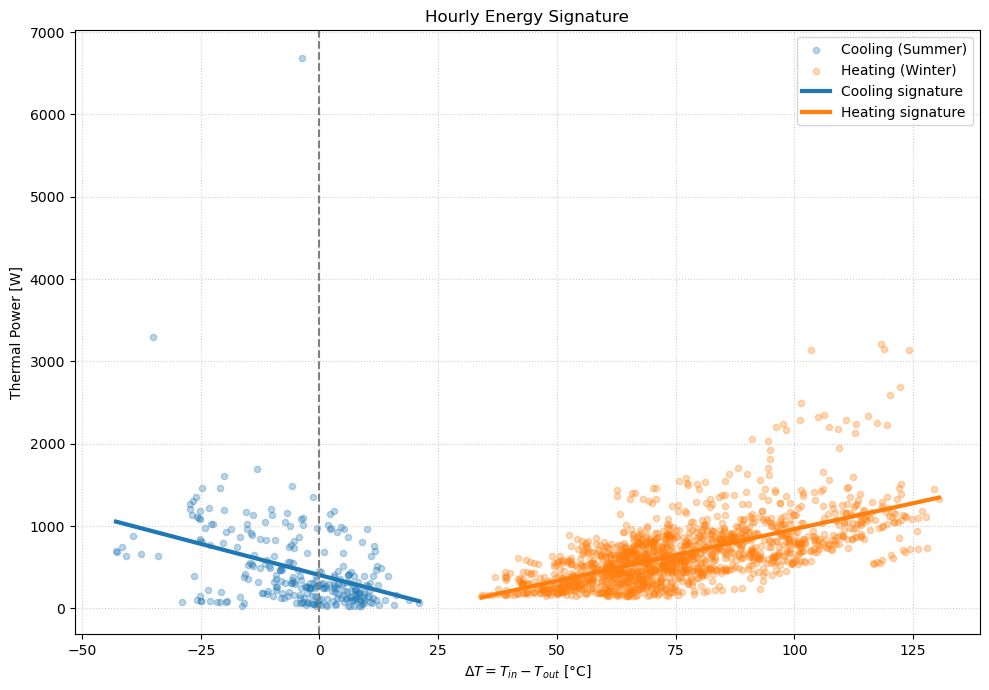

Executing query with GROUP BY time(1d)...
                   time  val             name
0  2025-01-01T00:00:00Z  NaN  DistrictCooling
1  2025-01-02T00:00:00Z  NaN  DistrictCooling
2  2025-01-03T00:00:00Z  NaN  DistrictCooling
3  2025-01-04T00:00:00Z  0.0  DistrictCooling
4  2025-01-05T00:00:00Z  0.0  DistrictCooling
Index(['time', 'val', 'name'], dtype='object')
['DistrictCooling' 'DistrictHeating' 'T_ext' 'Tair_z1' 'Tair_z2' 'Tair_z3'
 'Tair_z4']
Winter points before filtering: 179
Winter points after filtering: 117
Summer points before filtering: 183
Summer points after filtering: 29


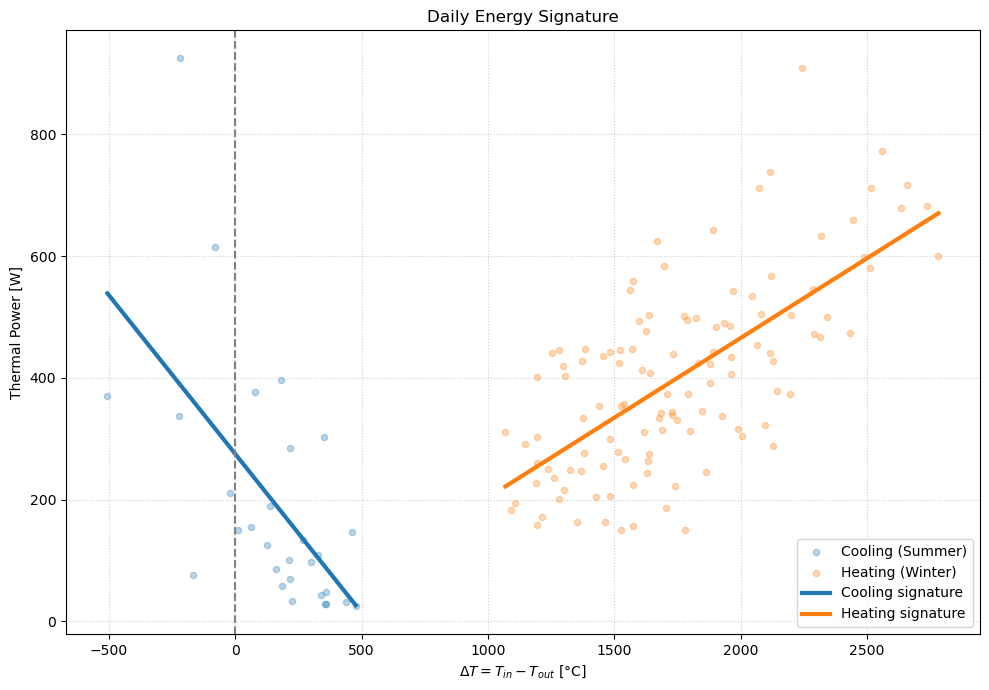

Executing query with GROUP BY time(7d)...
                   time  val             name
0  2024-12-26T00:00:00Z  NaN  DistrictCooling
1  2025-01-02T00:00:00Z  0.0  DistrictCooling
2  2025-01-09T00:00:00Z  0.0  DistrictCooling
3  2025-01-16T00:00:00Z  0.0  DistrictCooling
4  2025-01-23T00:00:00Z  0.0  DistrictCooling
Index(['time', 'val', 'name'], dtype='object')
['DistrictCooling' 'DistrictHeating' 'T_ext' 'Tair_z1' 'Tair_z2' 'Tair_z3'
 'Tair_z4']
Winter points before filtering: 26
Winter points after filtering: 17
Summer points before filtering: 26
Summer points after filtering: 7


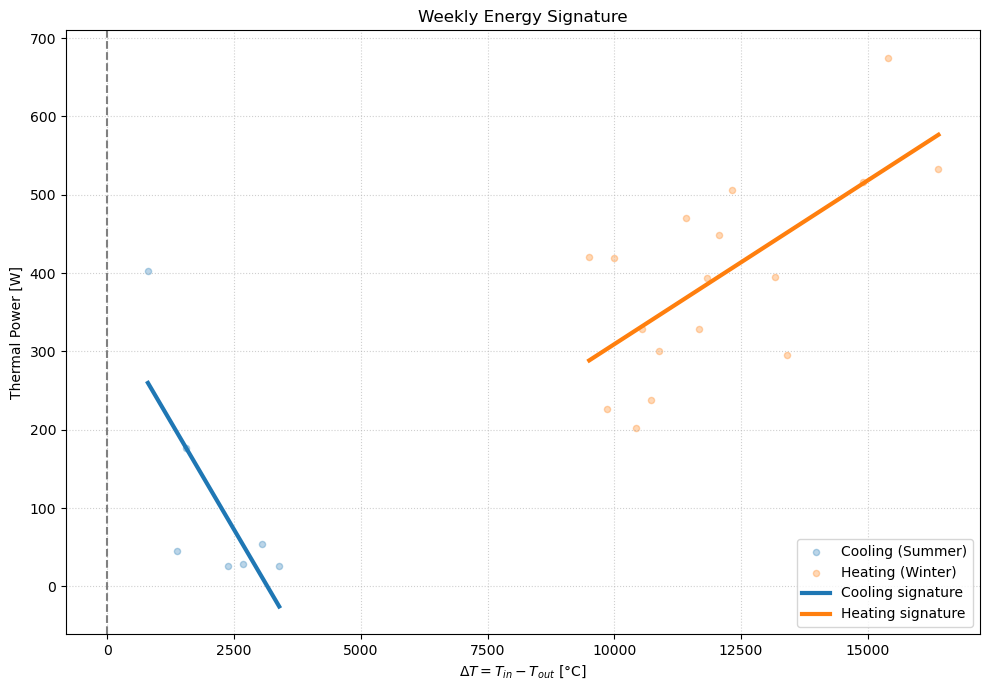

Executing query with GROUP BY time(30d)...
                   time  val             name
0  2024-12-13T00:00:00Z  0.0  DistrictCooling
1  2025-01-12T00:00:00Z  0.0  DistrictCooling
2  2025-02-11T00:00:00Z  0.0  DistrictCooling
3  2025-03-13T00:00:00Z  0.0  DistrictCooling
4  2025-04-12T00:00:00Z  0.0  DistrictCooling
Index(['time', 'val', 'name'], dtype='object')
['DistrictCooling' 'DistrictHeating' 'T_ext' 'Tair_z1' 'Tair_z2' 'Tair_z3'
 'Tair_z4']
Winter points before filtering: 7
Winter points after filtering: 7
Summer points before filtering: 6
Summer points after filtering: 4


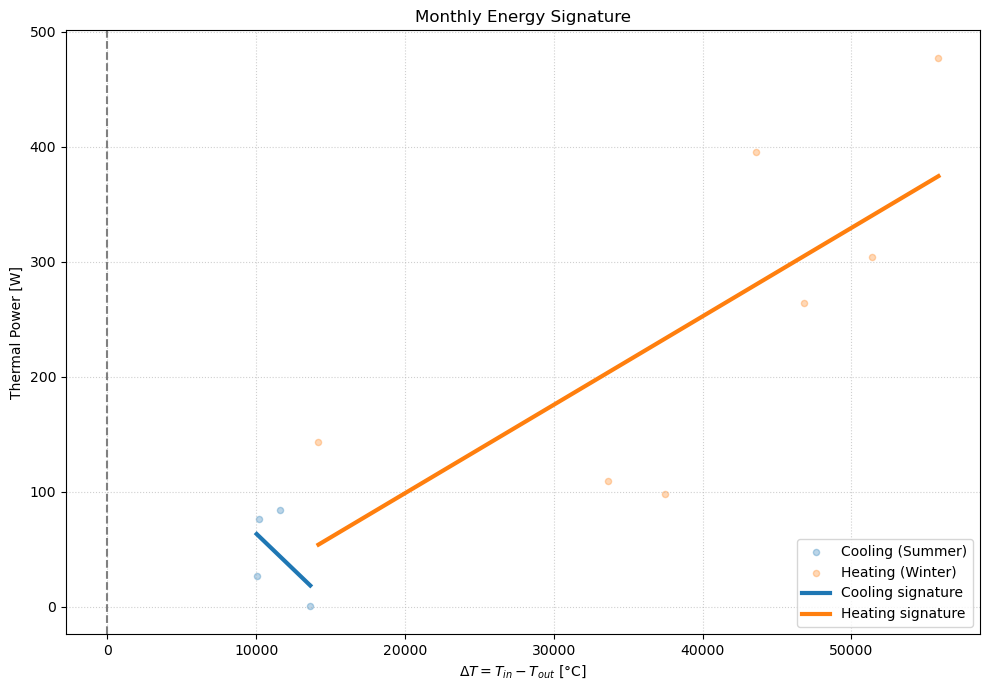

In [4]:
def plot_energy_signature(group_by_time, title, threshold_cooling, threshold_heating):
    """
    Plots the Energy Signature of the building based on InfluxDB data.
    
    Args:
        group_by_time (str): Time interval for grouping data (e.g., '1h', '30m').
        title (str): Title of the plot.
        threshold (float): Minimum power threshold to filter data points.
    
    Returns:
        None
    """
    # Query the specific FMU fields
    influxql_query = f'''
    SELECT SUM("value") AS "val"
    FROM "{MEASUREMENT}"
    WHERE time >= '{START}'
        AND time < '{END}'
        AND "name" =~ /^(DistrictHeating|DistrictCooling|Tair_z1|Tair_z2|Tair_z3|Tair_z4|T_ext)$/
    GROUP BY time({group_by_time}), "name"
    fill(previous)
    '''

    # Query Data and Process into DataFrame
    print(f"Executing query with GROUP BY time({group_by_time})...")
    result_set = client.query(influxql_query)

    records = []

    # Iterate over the result set to build a DataFrame
    for (m, tags), points in result_set.items():
        name_tag = tags.get('name')
        for p in points:
            p['name'] = name_tag # add the 'name' tag to each point
            records.append(p)

    df = pd.DataFrame(records)
    
    print(df.head())
    print(df.columns)
    print(df['name'].unique())

    if df.empty:
        print("No data returned.")
        return

    # Convert 'time' to datetime
    df['time'] = pd.to_datetime(df['time'])

    # Pivot the DataFrame to have separate columns for each 'name'
    df = df.pivot_table(
        index='time',
        columns='name',
        values='val'
    ).reset_index()

    # Get absolute values and convert in Watts
    dt_seconds = SECONDS_PER_INTERVAL[group_by_time]
    df['QH'] = df['DistrictHeating'].abs() / dt_seconds
    df['QC'] = df['DistrictCooling'].abs() / dt_seconds
    
    # Average indoor air temperature from zones
    df['T_in_avg'] = (
        df['Tair_z1'] +
        df['Tair_z2'] +
        df['Tair_z3'] +
        df['Tair_z4']
    ) / 4

    # Temperature difference
    df['Delta_T'] = df['T_in_avg'] - df['T_ext']

    # Remove rows with NaN values
    df = df.dropna(subset=['Delta_T', 'QH', 'QC'])

    # Split data into "Summer" (Cooling) and "Winter" (Heating) for coloring
    # Filter by Schedule (Oct-Mar = Heating, Apr-Sep = Cooling)
    month = df['time'].dt.month
    is_heating_season = (month <= 3) | (month >= 10)

    # WINTER (HEATING)
    df_winter = df[is_heating_season].copy()
    print(f"Winter points before filtering: {len(df_winter)}")

    # Filter out low heating power outliers
    if group_by_time != '30d':
        threshold = threshold_heating
    else:
        threshold = 0
    df_winter = df_winter[df_winter['QH'] > threshold]
    print(f"Winter points after filtering: {len(df_winter)}")

    # SUMMER (COOLING)
    df_summer = df[~is_heating_season].copy()
    print(f"Summer points before filtering: {len(df_summer)}")

    # Filter out low cooling power outliers
    if group_by_time != '30d':
        threshold = threshold_cooling
    else:
        threshold = 0
    df_summer = df_summer[df_summer['QC'] > threshold]
    print(f"Summer points after filtering: {len(df_summer)}")

    plt.figure(figsize=(10, 7))

    # Cooling signature (summer)
    plt.scatter(
        df_summer['Delta_T'],
        df_summer['QC'],
        label='Cooling (Summer)',
        color='tab:blue',
        alpha=0.3,
        s=20
    )

    # Heating signature (winter)
    plt.scatter(
        df_winter['Delta_T'],
        df_winter['QH'],
        label='Heating (Winter)',
        color='tab:orange',
        alpha=0.3,
        s=20
    )

    # Regression lines
    if len(df_summer) > 1:
        z_c = np.polyfit(df_summer['Delta_T'], df_summer['QC'], 1)
        p_c = np.poly1d(z_c)
        x = np.sort(df_summer['Delta_T'])
        plt.plot(x, p_c(x), linewidth=3, label='Cooling signature', color='tab:blue')

    if len(df_winter) > 1:
        z_h = np.polyfit(df_winter['Delta_T'], df_winter['QH'], 1)
        p_h = np.poly1d(z_h)
        x = np.sort(df_winter['Delta_T'])
        plt.plot(x, p_h(x), linewidth=3, label='Heating signature', color='tab:orange')

    plt.title(title)
    plt.xlabel(r'$\Delta T = T_{in} - T_{out}$ [°C]')
    plt.ylabel('Thermal Power [W]')
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the hourly energy signature
group_time_hour = '1h'
title_hour = f'Hourly Energy Signature'
plot_energy_signature(group_time_hour, title_hour, THRESHOLD_COOLING, THRESHOLD_HEATING)

# Plot the daily energy signature
group_time_day = '1d'
title_day = f'Daily Energy Signature'
plot_energy_signature(group_time_day, title_day, THRESHOLD_COOLING, THRESHOLD_HEATING)

# Plot the weekly energy signature
group_time_week = '7d'
title_week = f'Weekly Energy Signature'
plot_energy_signature(group_time_week, title_week, THRESHOLD_COOLING, THRESHOLD_HEATING)

# plot the monthly energy signature
group_time_month = '30d'
title_month = f'Monthly Energy Signature'
plot_energy_signature(group_time_month, title_month, THRESHOLD_COOLING, THRESHOLD_HEATING)